In [31]:
# Imports
import gc
import menpo.io as mio
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import shutil

from menpo.visualize import print_progress
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh, face_ibug_68_to_face_ibug_66_trimesh
from menpofit.aam import PatchAAM
from menpo.feature import fast_dsift
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
from menpodetect import load_dlib_frontal_face_detector
from menpofit.builder import warp_images
from menpofit.builder import build_reference_frame
from menpo.transform import PiecewiseAffine
from menpo.model import PCAModel
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support

from os.path import join, dirname, realpath

%matplotlib inline

# Table of contents
1. [Introduction](#introduction)
2. [Data Pre-Processing](#preprocessing)
3. [Train AAM](#aam)
4. [Feature Extraction](#feature)
5. [Model Training](#training)
6. [Model Evaluation](#evaluation)

### Introduction <a name="introduction"></a>

At this point, we have done an EDA (exploratory data analysis) of our dataset, and are now conducting a literature review to see what techniques are being applied in the pain detection domain. To recap, our dataset consists of around 48,000 color images of facial expressions along with associated pain labels - which tell us how much pain the subject is in (based on varying scales). We decide to use the PSPI score as our label because the other labels consist of self-reported scores given by the subjects themselves, and a score given by an independent observer. We felt that the PSPI score was the most objective rating out of all the scores provided (it is based on the intensity of certain facial expressions) and is widely used for pain detection tasks. Now that we have finalized our samples and labels, we can formalize our problem statement as the following: Given a color image of a person's face, our goal is to build a model that predicts whether the person is in pain or no pain.

After reading several papers, we came to the conclusion that the majority of research in the pain detection domain involves the use of SVM (Support Vector Machine) models. Therefore, we decided to use SVM as our baseline model to measure performance against. We base our approach below on the steps taken in the following [research paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3402903/pdf/nihms119293.pdf).

### Data Pre-Processing <a name="preprocessing"></a>

First, we need to pre-process the data so that it can be used to train our main SVM model. We read the labels and image paths from .npy files to ensure that the same input data is used for all of our models. Our pre-processing involves the following steps:

1. Converting the images to greyscale and resizing
2. Reformatting the AAM (Active Appearance model) landmark annotations to conform to Menpo's (a third-party statistical framework that we will discuss in more detail in the next section) expectations

In [2]:
root_path = os.getcwd()

images_path = join(root_path, 'SVM_Images')

images = []

labels = np.load('Images_Labels.npy')
print 'Sample raw label: {}'.format(label[0])

image_names = np.load(join(root_path, 'Image_Path.npy'))
print 'Sample image name: {}'.format(image_names[0])

In [25]:
# NOTE: this cell takes around 45 mins to run
import subprocess

reformat_pts_files_sh = '''
shopt -s nullglob

ex -sc '1i|{{' -cx "{pts_file}"
ex -sc '1i|n_points:  66' -cx "{pts_file}"
ex -sc '1i|version: 1' -cx "{pts_file}"
echo "}}" >> {pts_file}
'''

# reformat AAM annotations and move them to image locations
for subject in os.listdir(aam_path):
    if subject != '.DS_Store':
        for sequence in os.listdir(join(aam_path, subject)):
            if sequence != '.DS_Store':
                for aam_file_src in os.listdir(join(aam_path, subject, sequence)):
                    if aam_file_src != '.DS_Store':
                        aam_file_dst = '{}.pts'.format(aam_file_src.split('_')[0])
                        aam_file_src_path = join(aam_path, subject, sequence, aam_file_src)
                        aam_file_dst_path = join(images_path, subject, sequence, aam_file_dst)
                        
                        shutil.copyfile(aam_file_src_path, aam_file_dst_path)
                        subprocess.check_call(reformat_pts_files_sh.format(pts_file=aam_file_dst_path), shell=True)

In [4]:
for image_name in image_names:
    image_path = join(images_path, '/'.join(image_name.split('/')[-3:]))

    img = mio.import_image(image_path)
    # convert to greyscale
    if img.n_channels == 3:
        img = img.as_greyscale()
    # crop to landmarks bounding box with an extra 20% padding
    img = img.crop_to_landmarks_proportion(0.2)
    # rescale image if its diagonal is bigger than 400 pixels
    d = img.diagonal()
    if d > 400:
        img = img.rescale(400.0 / d)
    # append to list
    images.append(img)

In [5]:
print 'Number of images loaded: {}'.format(len(images))
print 'Number of 0 (no pain) labels loaded: {}'.format(len(filter(lambda x: x == 0.0, labels)))
print 'Number of 1 (pain) labels loaded: {}'.format(len(filter(lambda x: x != 0.0, labels)))

Number of images loaded: 16739
Number of 0 (no pain) labels loaded: 8370
Number of 1 (pain) labels loaded: 8369


In [6]:
# force garbage collection to free up some memory
del image_names

gc.collect()

84

### Train AAM <a name="aam"></a>

Our next step is to train an AAM (Active Appearance Model). An Active Appearance model provides a statistical representation of the shape and appearance of 2D facial images. To train the AAM, we use a third-party statistical framework called Menpo because it abstracts the math away and makes the model training process relatively easy. It measures the AAM model accuracy by fitting the model against an image in the dataset and looking at how well the model is able to annotate the facial features in the image.

In [7]:
patch_aam = PatchAAM(images[:2000], group='PTS', patch_shape=[(15, 15), (23, 23)],
                     diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
                     max_shape_components=20, max_appearance_components=150,
                     verbose=True)

- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (2000/2000) - done.                
  - Scale 0: Doneding appearance model                                          ngining
  - Scale 1: Doneding appearance model                                          ing
                                                              

In [8]:
fitter = LucasKanadeAAMFitter(patch_aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])

/opt/conda/envs/menpo/lib/python2.7/site-packages/menpo/shape/pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


Fitting result of 66 landmark points.
Initial error: 0.2304
Reconstructed initial error: 0.2304
Final error: 0.2732


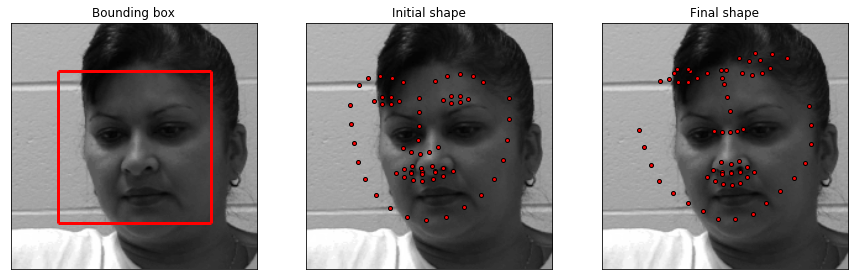

In [9]:
# Load detector
detect = load_dlib_frontal_face_detector()

# Load and convert to grayscale
image = mio.import_image(join(images_path, '042-ll042', 'll042t1aaaff', 'll042t1aaaff242.png'))
image = image.as_greyscale()

# Detect face
bboxes = detect(image)

# Crop the image for better visualization of the result
image = image.crop_to_landmarks_proportion(0.3, group='dlib_0')
bboxes[0] = image.landmarks['dlib_0'].lms

if len(bboxes) > 0:
    # Fit AAM
    result = fitter.fit_from_bb(image, bboxes[0], max_iters=[15, 5],
                                gt_shape=image.landmarks['PTS'].lms)
    print(result)

    # Visualize
    plt.subplot(131)
    image.view()
    bboxes[0].view(line_width=3, render_markers=False)
    plt.gca().set_title('Bounding box')

    plt.subplot(132)
    image.view()
    result.initial_shape.view(marker_size=4)
    plt.gca().set_title('Initial shape')

    plt.subplot(133)
    image.view()
    result.final_shape.view(marker_size=4, figure_size=(15, 13))
    plt.gca().set_title('Final shape')

In [10]:
# force garbage collection to free up some memory
del patch_aam
del fitter

gc.collect()

11965

### Feature Extraction <a name="feature"></a>

After we have trained the AAM, we will transform the raw images by applying a mask; which will remove rigid geometric variation by warping the pixels in the source image with respect to translation, rotation, and scale. After this warping operation has been applied, we will use the resulting image pixels as the features for our SVM model. We then transform the labels (PSPI scores) from their original ordinal values to 0/1 (to represent pain and no pain binary classification output).

Finally, we split our samples into training/test sets to prepare for model training and evaluation.

NOTE: in the paper we are referencing, they apply other transformations to the source images to generate other features. They then try these various feature sets out to see which one results in the best model performance. However, we opt to just use this single feature set in the interest of time.

In [8]:
result.final_shape

PointCloud: n_points: 66, n_dims: 2

In [9]:
print images[0].landmarks.get('PTS')

PointCloud: n_points: 66, n_dims: 2


In [11]:
# extract shapes from images
shapes_an = [i.landmarks.get('PTS') for i in images]

# build reference frame
reference_frame_an = build_reference_frame(result.final_shape)

# Apply piece-wise affine warp on source images
warped_images_an = warp_images(images, shapes_an, reference_frame_an, PiecewiseAffine)

/opt/conda/envs/menpo/lib/python2.7/site-packages/menpofit/builder.py:338: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)
/opt/conda/envs/menpo/lib/python2.7/site-packages/menpo/image/boolean.py:711: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  copy.pixels[slices].flat = point_in_pointcloud(pointcloud, indices)


In [12]:
warped_images_an[0]

146W x 141H 2D MaskedImage with 1 channels. Attached mask 68.9% true

In [13]:
s_app = warped_images_an

In [14]:
final_training_images = s_app
# transform PSPI labels into 0/1 (pain vs no pain)
final_training_labels = [int(label > 0.0) for label in labels]

In [15]:
print final_training_labels[:10]
print 'Number of labels showing pain: {}'.format(sum(final_training_labels))
print 'Number of labels showing no pain: {}\n'.format(len(final_training_labels) - sum(final_training_labels))

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Number of labels showing pain: 8369
Number of labels showing no pain: 8370



In [16]:
# transform images into list of pixel values
vectorized_training_images = [sample.as_vector().tolist() for sample in final_training_images]
np.unique(list(map(len, vectorized_training_images)))

array([14193])

In [17]:
# force garbage collection to free up some memory
del images
del final_training_images
del warped_images_an
del s_app
del result

gc.collect()

66950

In [18]:
# Add labels to samples for k-means clustering
samples = []
for image_idx, training_image in enumerate(vectorized_training_images):
    sample = training_image + [final_training_labels[image_idx]]
    samples.append(sample)

In [19]:
# force garbage collection to free up some memory
del vectorized_training_images

gc.collect()

2

In [20]:
# Split data into train/test sets
# Possible Future enhancement: use k-fold cross-validation instead of one static split
training_percentage = 0.8
k = int(len(samples) * training_percentage)

training_indices = random.sample(xrange(len(samples)), k)
test_indices = list(set(range(len(samples))) - set(training_indices))

training_samples = [samples[index] for index in training_indices]
test_samples = [samples[index] for index in test_indices]

In [21]:
print(len(training_samples))
print(len(test_samples))

13391
3348


#### K-Means Clustering

In our initial approach, we wanted to apply k-means clustering to reduce the size of the training set being fed into the SVM to reduce training time and memory usage (this was also done in the paper we referenced). However, we later realized that since our dataset is so small, this clustering step is unnecessary and SVM does not take too long to train. We were also able to free up memory by periodically forcing garbage collection - and found this to be enough to manage memory usage.

We have included this section for completeness, but it was not used in our final run.

In [ ]:
num_kmeans_clusters = 1000

In [ ]:
kmeans = KMeans(n_clusters=num_kmeans_clusters, random_state=0).fit(training_samples)

In [ ]:
# Pull training samples from clusters
cluster_ids = set(range(num_kmeans_clusters))
final_training_samples = []

for training_sample_idx, cluster_id in enumerate(kmeans.labels_.tolist()):
    if cluster_id in cluster_ids:
        final_training_samples.append(training_samples[training_sample_idx])
        cluster_ids.remove(cluster_id)

### Model Training <a name="training"></a>

We now train an SVM model using our features and labels generated from the sections above.

In [22]:
# Separate samples from labels
svm_training_labels = [sample[-1] for sample in training_samples]
svm_training_samples = [sample[:-1] for sample in training_samples]

svm_test_labels = [sample[-1] for sample in test_samples]
svm_test_samples = [sample[:-1] for sample in test_samples]

In [23]:
# SVM Training
clf = svm.SVC(gamma='scale')
clf.fit(svm_training_samples, svm_training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Model Evaluation <a name="evaluation"></a>

After training our SVM model, we evaluate it by using our test set. We collect the model's predictions of pain/no pain on the test set, and compare them against the true values to gauge model performance.

In [24]:
predictions = clf.predict(svm_test_samples).tolist()

In [25]:
predictions[10]

0

In [26]:
sum(predictions)

1562

In [27]:
sum(svm_test_labels)

1669

[Text(0,0.5,'no pain'), Text(0,1.5,'pain')]

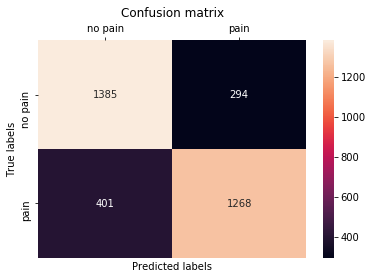

In [28]:
cm = confusion_matrix(svm_test_labels, predictions)

# plot heatmap of confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
plt.title('Confusion matrix', y=1.08)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.tick_top()
ax.xaxis.set_ticklabels(['no pain', 'pain'])
ax.yaxis.set_ticklabels(['no pain', 'pain'])

From the confusion matrix above, we can see that the model performed relatively well on classifying both pain and no pain samples. The model was able to correctly classify 1385/1679 no pain samples (82.5% accuracy), and was able to correctly classify 1268/1669 pain samples (76.0% accuracy). We look at other metrics below to get a better understanding of overall model performance.

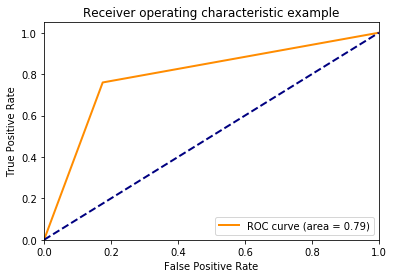

In [29]:
# Compute ROC curve and ROC area for pain class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(svm_test_labels, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [30]:
accuracy = float(sum([predictions[i] == svm_test_labels[i] for i in range(len(svm_test_labels))])) / float(len(predictions))
scores = precision_recall_fscore_support(svm_test_labels, 
                                         predictions, 
                                         beta=1.0, 
                                         labels=None, 
                                         pos_label=1, 
                                         average='binary', 
                                         warn_for=('precision', 'recall', 'f-score'), 
                                         sample_weight=None)

print 'Model accuracy: {}\n'.format(accuracy)
print 'Model precision: {}\n'.format(scores[0])
print 'Model recall: {}\n'.format(scores[1])
print 'Model F1 Score: {}\n'.format(scores[2])

Model accuracy: 0.792413381123

Model precision: 0.811779769526

Model recall: 0.759736369083

Model F1 Score: 0.78489631693



From these additional metrics and visualizations, we can see that the model had an accuracy of 79.2% and the high F1 score reinforces the fact that it performed consistently on both the pain and no pain samples.

#### Data Augmentation

We augmented our data by transforming the source images (by rotating and flipping the images), but did not use this augmented data to train the SVM model because it would have required manually generating new AAM annotations for each new image (which would have taken a long time).